In [3]:
import cenpy as c
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Cenpy gives us access to a variety of US Census databases. We can see which ones via the `explorer` module:

In [7]:
dbs = c.explorer.available()
print('Number of databases: ', len(dbs))
print('First five databases: ', dbs[:5])

Number of databases:  262
First five databases:  ['CBP2000', 'CPSPoverty', 'ACSFlows2014', 'ACSDT1Y2016', 'EITSMWTS']


We're going to look at the database called `ACSSF5Y2056`. This is the American Community Survey Summary File, providing 5 year estimates from 2011-2015. The `explorer` module provides us a method to access a detailed description of the database:

In [15]:
acs_db = 'ACSSF5Y2015'
c.explorer.explain(acs_db)

{'2011-2015 American Community Survey 5-Year Estimates': 'The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population.  Summary files include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts (114th congress), all counties, all places, and all tracts and block groups.  Summary files contain the most detailed cross-tabulations, many of which are published down to block groups. The data are population and housing counts. There are over 64,000 variables in this dataset.'}

To access data from this database, we need to establish a connection to the US Census Bureau server. This might take a few seconds.

In [17]:
connection = c.base.Connection(acs_db)

The `geographies` dataframe provides the FIPS codes for each type of region defined by the Census Bureau. The first column indicates the `geoLevelId`, which is the unique identifier for a specific type of region. The `name` column describes that region, and the `requires` column describes the regions that our specific geographic ID needs before it can be specified. For example, the geo ID 150 specifies a block group, and it requires a state, county, and tract ID.

In [30]:
geographies = connection.geographies['fips']
geographies[geographies.geoLevelId == '150']

,geoLevelId,name,optionalWithWCFor,requires,wildcard
22,150,block group,tract,"[state, county, tract]",[tract]


We have a mechanism for identifying geographies. Next, we need to choose specific data that we're interested in. That's given by the `variables` dataframe:

In [34]:
variables = connection.variables
variables.head(10)

,concept,group,label,limit,predicateOnly,predicateType,required,validValues
AIANHH,Selectable Geographies,N/A,FIPS AIANHH code,0,NaN,NaN,NaN,[]
AIHHTLI,Selectable Geographies,N/A,American Indian Trust Land/Hawaiian Home Land ...,0,NaN,NaN,NaN,[]
AITS,Selectable Geographies,N/A,American Indian Tribal Subdivision (FIPS),0,NaN,NaN,NaN,[]
AITSCE,Selectable Geographies,N/A,American Indian Tribal Subdivision (Census),0,NaN,NaN,NaN,[]
ANRC,Selectable Geographies,N/A,Alaska Native Regional Corporation (FIPS),0,NaN,NaN,NaN,[]
B00001_001E,B00001. Unweighted Sample Count of the Popula...,N/A,Total,0,NaN,int,NaN,[]
B00001_001M,B00001. Unweighted Sample Count of the Popula...,N/A,Margin Of Error For!!Total,0,NaN,int,NaN,[]
B00002_001E,B00002. Unweighted Sample Housing Units,N/A,Total,0,NaN,int,NaN,[]
B00002_001M,B00002. Unweighted Sample Housing Units,N/A,Margin Of Error For!!Total,0,NaN,int,NaN,[]
B01001A_001E,B01001A. SEX BY AGE (WHITE ALONE),N/A,Total:,0,NaN,int,NaN,[]


Let's focus on `B00001_001E`. The `concept` column provides more information on it:

In [43]:
col = 'B00001_001E'
print(variables.loc[col].concept)

B00001.  Unweighted Sample Count of the Population


Our goal now is to grab the population sample counts in all the block groups of Alameda County. To do this, we need the FIPS IDs for California and Alameda - they're 06 and 001, respectively. We'll access the data via the query function. It requires a `geo_unit`, which is the name for the geographic level that we'd like to access the data at (it'll be `'block group'`) and a `geo_filter`, which is a dictionary of all the required elements. While block groups require a state, county, and tract, we're only going to provide the first two. 

In [45]:
geo_unit = 'block group'
geo_filter = {'state' : '06', 'county' : '001'}

In [47]:
db_query = connection.query(cols=['NAME', col], geo_unit=geo_unit, geo_filter=geo_filter)
db_query.head(10)

/usr/local/lib/python3.5/site-packages/cenpy/remote.py:172: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df[cols] = df[cols].convert_objects(convert_numeric=convert_numeric)


,NAME,B00001_001E,state,county,tract,block group
0,"Block Group 1, Census Tract 4001, Alameda Coun...",301.0,06,001,400100,1
1,"Block Group 1, Census Tract 4002, Alameda Coun...",186.0,06,001,400200,1
2,"Block Group 2, Census Tract 4002, Alameda Coun...",142.0,06,001,400200,2
3,"Block Group 1, Census Tract 4003, Alameda Coun...",63.0,06,001,400300,1
4,"Block Group 2, Census Tract 4003, Alameda Coun...",94.0,06,001,400300,2
5,"Block Group 3, Census Tract 4003, Alameda Coun...",49.0,06,001,400300,3
6,"Block Group 4, Census Tract 4003, Alameda Coun...",94.0,06,001,400300,4
7,"Block Group 1, Census Tract 4004, Alameda Coun...",134.0,06,001,400400,1
8,"Block Group 2, Census Tract 4004, Alameda Coun...",111.0,06,001,400400,2
9,"Block Group 3, Census Tract 4004, Alameda Coun...",117.0,06,001,400400,3


We've queried the name of the geographic region along with the population count in that region. We can plot a histogram of counts: 

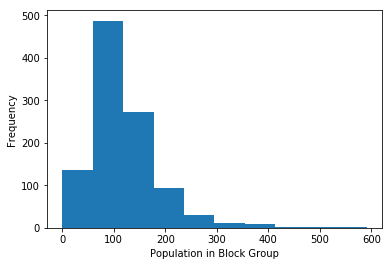

In [51]:
plt.hist(db_query[col].loc[db_query[col].notnull()])
plt.xlabel('Population in Block Group')
plt.ylabel('Frequency')
plt.show()